# 01: Plotting data, uncertainty, curve fits

The bread-and-butter of any experimental scientist is plotting data and visualizing uncertainty in that data. Often, we also want to fit a curve to that data and extract some model parameters for comparing different conditions. We'll work through a few ways to do that here. 

***
## Plotting mean +/- standard deviation
First, let's say we have some data, such as spectra, that we want to average and plot with its standard deviation. Let's generate some fake normally-distributed data with uniformly-distributed noise.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
np.random.seed(42)           # For reproducibility

# Define a normal distribution
def normal(x,μ,σ):
    return 1/ (2*np.pi*σ**2)*np.exp(-(x-μ)**2/(2*σ**2))

mu1 = 530
mu2 = 560
sigma = 10
wavelengths = np.arange(500,600,10)
n_wvs = len(wavelengths)
fluorescence1 = 1000*normal(wavelengths,mu1,sigma)
fluorescence2 = 1000*normal(wavelengths,mu2,sigma)

Let's say we have three replicate spectra for each of two different conditions. Let's put them into a numpy array with each replicate in a column. Note that, because of how numpy and matplotlib handle vectors (such as "wavelengths" above), it really will be easiest if your data is arranged with samples in columns.

Of course, you wouldn't be assembling your data this way, you would just import it from your file and put it in a similar numpy array.

In [21]:
n_reps = 3
data1 = np.tile(fluorescence1,[n_reps,1]).T + np.random.rand(n_wvs,n_reps)
data2 = np.tile(fluorescence2,[n_reps,1]).T + np.random.rand(n_wvs,n_reps)
data = np.append(data1,data2,1)
print(pd.DataFrame(data)) # The pandas "DataFrame" call is just to make the data easier to visualize

          0         1         2         3         4         5
0  0.392221  0.968395  0.749674  0.607545  0.170524  0.065052
1  0.814051  0.371411  0.371387  0.948891  0.965638  0.808403
2  1.023407  1.831500  1.566439  0.305148  0.098206  0.684767
3  2.299622  1.612134  2.561459  0.457833  0.139719  0.512857
4  1.797766  1.177663  1.147148  0.249781  1.124713  0.474173
5  0.398797  0.519635  0.740149  1.627846  1.277035  1.485392
6  0.449626  0.308910  0.629533  2.138260  1.776404  2.561134
7  0.140028  0.292679  0.366896  1.740456  1.904822  1.860151
8  0.456076  0.785182  0.199680  0.813293  1.137267  0.303885
9  0.514234  0.592415  0.046450  0.213663  0.062908  0.343011


First, let's take the average and standard deviation across the replicates by specifying "axis = 1". Using "0" instead would have taken the average down each column. Specifying nothing would take the average of the whole array!

In [22]:
mn1 = np.mean(data[:,:n_reps], axis=1) #Note that we also could have done "data.mean(1)"
sd1 = np.std(data[:,:n_reps], axis=1) #Same here with "data.std(1)"

mn2 = data[:,n_reps:].mean(1)
sd2 = data[:,n_reps:].std(1)

We can plot the mean of each point with error bars, or we can plot the mean as a continuous line with a shaded region indicating the SD.

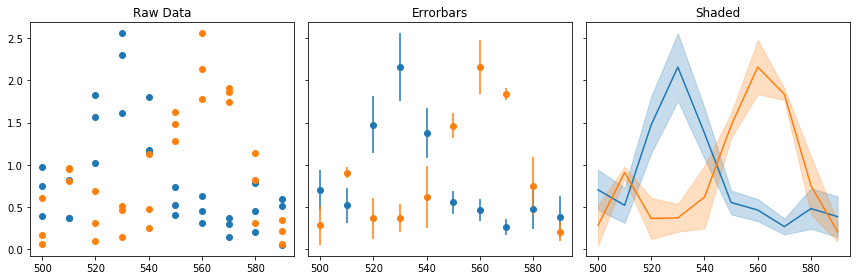

In [23]:
fig,(raw_ax, ebar_ax, shade_ax) = plt.subplots(1, 3, sharex = 'all', sharey = 'all', figsize = (12,4))

raw_ax.plot(wavelengths,data[:,:n_reps],'o',color = 'C0')
raw_ax.plot(wavelengths,data[:,n_reps:],'o',color = 'C1')
raw_ax.set_title('Raw Data')

ebar_ax.errorbar(wavelengths, mn1, sd1, marker = 'o', ls = 'none')
ebar_ax.errorbar(wavelengths, mn2, sd2, marker = 'o', ls = 'none')
ebar_ax.set_title('Errorbars')

shade_ax.plot(wavelengths,mn1)
shade_ax.fill_between(wavelengths, mn1 + sd1, mn1 - sd1, color = 'C0', alpha = 0.25, edgecolor = 'none')
shade_ax.plot(wavelengths,mn2)
shade_ax.fill_between(wavelengths, mn2 + sd2, mn2 - sd2, color = 'C1', alpha = 0.25, edgecolor = 'none')
shade_ax.set_title('Shaded')

fig.tight_layout() # When using subplots, you'll almost always want to call this *after* specifying titles, axes labels, etc

***
## Fitting a simple line to your data

Often, all you want is a linear fit to your data. There are several ways to do this, but there are a couple methods tailored to simply fits. First, let's make some fake linear data with normally-distributed scatter:

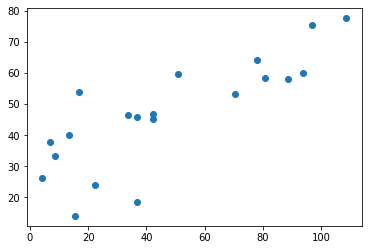

In [24]:
intercept_true = 25
slope_true = 0.5
x = 100 * np.random.random(20)
y = intercept_true + slope_true * x

# add scatter to points
x = np.random.normal(x, 10)
y = np.random.normal(y, 10)

plt.plot(x, y, 'o');

Scipy's stats module provides __[`linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)__, a function optimized for linear fits and only linear fits, but it automatically calculates various parameters for you like the p-value that the slope is not zero or the correlation coefficient $R$ (note, not $R^2$).

LinregressResult(slope=0.42203317848199157, intercept=26.979536164450522, rvalue=0.8135993479830751, pvalue=1.2830608542837104e-05, stderr=0.07108764700605835)

      slope  intercept    rvalue    pvalue    stderr
0  0.422033  26.979536  0.813599  0.000013  0.071088


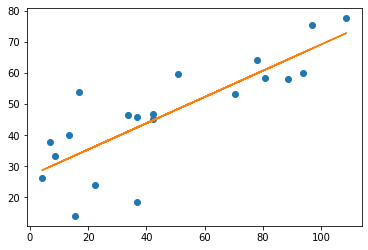

In [25]:
regress_output = stats.linregress(x,y)
print(regress_output)
print()
print(pd.DataFrame(regress_output._asdict(),index = range(1)))
plt.plot(x,y,'o')
plt.plot(x,regress_output.intercept + regress_output.slope * x);

We can also use Numpy's __[`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)__, which allows us to fit a polynomial of any order.  It also provides the `poly1d` function to create an operator that acts on input `x`-values in the way we'd expect.  Note that the coefficients for both functions are returned from highest to lowest order.

Estimated slope: 0.42
Estimated intercept: 26.98


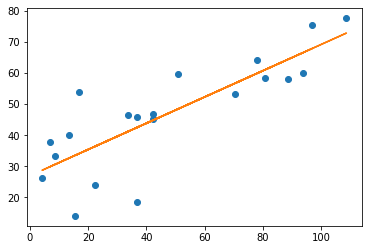

In [26]:
p_fit_lin,p_cov_lin = np.polyfit(x,y,1, cov = True)
[slope_est,intercept_est] = p_fit_lin                       
print('Estimated slope: {:.2f}'.format(slope_est))
print('Estimated intercept: {:.2f}'.format(intercept_est))
lin_fit = np.poly1d([slope_est,intercept_est]) # also could have done np.poly1d(*p_fit)
plt.plot(x,y,'o')
plt.plot(x,lin_fit(x));

However, `polyfit` doesn't automatically give us statistics on our fit, so we have to do the calculations manually. Everyone gets a bit twitchy without $R^2$ values so we'll calculate it here, even though they're not as useful as $\chi^2$ values (calculated below).

In [27]:
residuals_lin = y - lin_fit(x)
ss_res_lin = np.sum(residuals_lin**2)
ss_tot_lin = np.sum((y-np.mean(y))**2)
r2_lin = 1 - (ss_res_lin / ss_tot_lin)       # R^2, a measure of correlation
print('R^2 = {:.3f}'.format(r2_lin))

R^2 = 0.662


The 95% Confidence Interval, which reflects the probability of the value predicted by the fit ($\mu$) at each point $x_0$ is calculated from the 97.5 percentile of a Student's t-distribution with n-m degrees of freedom ($T_{n-m}^{.975}$) and the overall standard error of the fit ($\hat{\sigma}$):

$$ \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-m}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}} $$

where $$ \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}} $$

And the 95% Prediction Interval, which reflects the probability of where a new observation $y_0$ might lie, is give by:

$$ \left| \: \hat{y}_0 - y_0 \: \right| \; \leq \; T_{n-m}^{.975} \; \hat{\sigma} \; \sqrt{1 + \frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}} $$

Sources:
* M. Duarte.  "Curve fitting," Jupyter Notebook. http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb 
* https://stackoverflow.com/a/28336695)

Let's set up a couple functions to calculate these values based on our observed x-data for a range of x-values that we wish to plot (`xplot`). Note that these values only depend on the t-value for our model (that is, the *degrees of freedom*) and the standard error at each point (`s_err`), not the model predictions at any point.

In [28]:
def CI(x, xplot, t, s_err, n):
    return t * s_err * np.sqrt(1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

def PI(x, xplot, t, s_err, n):
    return t * s_err * np.sqrt(1 + 1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

Now let's calculate the error parameters for our fit:

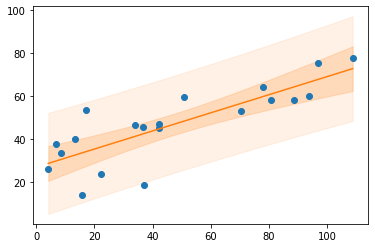

In [29]:
n = y.size
m = p_fit_lin.size
dof_lin = n-m                                         # Degrees of freedom
t = stats.t.ppf(0.975, n - m)                         # Student's t distribution
chi2 = np.sum((residuals_lin / lin_fit(x))**2)        # chi-squared; estimates error in fit
chi2_red = chi2 / dof_lin                             # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(residuals_lin**2) / dof_lin)   # standard error of the fit at each point
p_std_lin = np.sqrt(np.diag(p_cov_lin))               # Uncertainty on each output parameter

xplot = np.linspace(x.min(),x.max(),100)
ci_lin = CI(x,xplot,t, s_err, n)
pi_lin = PI(x,xplot,t, s_err, n)
yplot = lin_fit(xplot)

plt.plot(x,y,'o')
plt.fill_between(xplot, yplot + pi_lin, yplot - pi_lin, color = 'C1', alpha = 0.1)
plt.fill_between(xplot, yplot + ci_lin, yplot - ci_lin, color = 'C1', alpha = 0.2)
plt.plot(xplot,yplot, color = 'C1');

Note the hourglass shape of the confidence interval. This follows our intuition of how accurate the fit is: error in either of the fit parameters will result in a bigger change at the ends of our range than in the middle. Also note that many of the data points are outside the 95% CI, since the CI reflects the confidence on the fit itself, not the data. However, most of the data points (95%, in fact) are within the 95% PI, since this reflects the spread in the data.

***
## Fitting a more complicated curve to your data
Nature isn't so nice to us to only provide linear relationships, so what if you have something more complicated than a straight line or polynomial? What if you've come up with a new function that no one's ever seen before? That's where Scipy's __[`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)__ comes in. It takes a little more work to set up, but it's very powerful and very flexible.

Let's say you have dose-response data that you wish to fit with a Langmuir-Hill sigmoidal curve, given by

$$ Signal = Signal_0 + \frac{Signal_{max} - Signal_0}{1 + 10^{\left( x_{crit}-x \right)*b}} $$

The *inflection point* of the curve, occurring at `x_crit` is given various names depending on the application: EC<sub>50</sub> or IC<sub>50</sub> for drugs, K<sub>D</sub> for adsorption or ligand binding. It's important to note also that the x-data should typically be in log<sub>10</sub> format. The *Hill parameter* `b` defines the sharpness of the transition.

First we define a function that calculates the output of our equation for a set of input parameters:

In [30]:
def Hill_eq(x,S0,Smax,x_crit,b):
    return S0 + ( Smax - S0 )/( 1 + 10**((x_crit-x)*b) )

Now we set up our input concentrations and generate fake noisy response data (*in columns*) for some reasonable inputs:

In [31]:
np.random.seed(42)           # For reproducibility

c = concentrations = 10**-np.arange(5.,12.)
lg_c = np.log10(c)
r = response = Hill_eq(lg_c,0.3,1.5,-8,1.4)

n_reps = 3
data = np.tile(r,[n_reps,1]).T + np.random.rand(c.size,n_reps)*0.2

Technically this is all we need to give the function, but if we only give it the data the fit might fail. Why? Because `curve_fit`, like all fitting algorithms, is going to guess an initial value for each parameter, see how close those parameters are to fitting the data, then update them, check again, update according to whether the previous change made the fit better or worse, then iterate on and on (by default, about 1000 times) until it updating the parameters results in little change in the goodness-of-fit. The problem is the default guesses can be way off, and the algorithm can get "stuck" with parameter values that are far from optimal. It works best if we can provide some reasonable guesses for the equation parameters based on the data or what we know about the system. Most dedicated fitting software, such as GraphPad, probably do something similar behind the scenes. We can also provide ranges for the optimization algorithm to work in, if we know, e.g., that a given parameter will always be positive or is bounded between 0 and 1.

We'll start with obvious guess for `S0` and `Smax` as the minimum and maximum values of our data, and assume the Hill coefficient is near 1. We'll guess that `x_crit` is the x-value where your data crosses the halfway point between `S0` and `Smax`. Note, `argmax` is kind of a hack-y way of doing this. It returns the position of the maximum value of an array (rather than the maximum value itself). The input here, `np.argmax(data[:,0] < (Smax_g-S0_g)/2+S0_g)`, is a boolean array of `True`/`False` values. This approach relies on both a) the fact that `argmax` returns the *first* position where the maximum value is found (in this case, `True` is the maximum value), and b) that your data is sorted from highest-to-lowest in terms of concentrations. If your data was reversed and you didn't switch the `<`, your maximum value would be at the first position in your array. Another approach would be to use `searchsorted` (as per __[this](https://stackoverflow.com/a/25032853)__ post), but that has its own complications. So use with caution, and be sure to be consistent with your data.

In [32]:
# Guess parameters
S0_g = data.min()
Smax_g = data.max()
x_crit_g = lg_c[np.argmax(data[:,0] < (Smax_g-S0_g)/2+S0_g)]
b_g = 1
guesses = (S0_g, Smax_g, x_crit_g, b_g)

We provide `curve_fit` with the mean at each x-value along with the standard deviation as the error (`sigma`). It is crucial that we provide the `absolute_sigma = True` flag to `curve_fit` here. This tells the algorithm that our uncertainties in `sigma` are in the same units of the data; otherwise it assumes them to be simply relative weights of arbitrary magnitude. Calculating the the standard error of each parameter (as we do later on below) from a covariance matrix `p_cov` obtained without `absolute_sigma = True` will give us different, non-physical values.

In [33]:
p_opt_Hill, p_cov_Hill = opt.curve_fit(Hill_eq, lg_c, data.mean(1), sigma = data.std(1),
                                       p0 = guesses, absolute_sigma = True)
print(p_opt_Hill)

[ 0.37916459  1.59429154 -8.02600538  1.425394  ]


There, our fit worked! Let's plot the result. Our `Hill_eq` function takes five inputs (`x`, `S0`, `Smax`, `x_crit`, and `b`), but we're too lazy to assign each output parameter from `curve_fit` to its own variable then type them *again* as inputs to `Hill_eq`. We're even too lazy to type out `p_opt_Hill[0], p_opt_Hill[1], ...` etc. Ugh. Life's hard. Luckily Python is clever, and enables our laziness by allowing us to store all the outputs into one variable and then *unwrap* those individual values by prepending `*` before that variable. Phew. That could have gotten ugly.

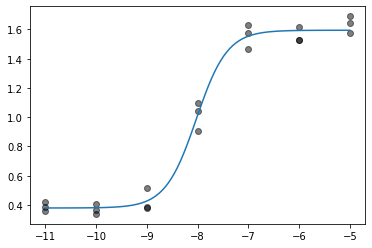

In [34]:
cplot = np.linspace(lg_c.min(),lg_c.max(),100)

hill_y = Hill_eq(cplot,*p_opt_Hill)

plt.plot(lg_c,data,'ko', alpha = 0.5)
plt.plot(cplot,hill_y,'C0');

Looks good! Try performing the fit again, but without the `guesses`, see how well it does (or doesn't do)! For this relatively simple curve and evenly-spaced data, the default parameters probably behave well, but it's still good to get in the habit of supplying initial guesses. 

Now let's calculate our 95% CI and 95% PI ranges for this fit, as we did above. This time, though, we'll do it in a nice neat function. This particular method of finding the intervals is the "classical approach" that rests upon a lot of assumptions. Later on, we'll explore other approaches with fewer (or at least different) assumptions. The words *bootstrap* and *Bayesian* will come up...

In [35]:
def classical_fit_intervals(func,p_opt,x,y,xplot):
    tile_x = np.tile(x,[y.size//x.size,1]).T
    n = y.size
    m = p_opt.size
    dof = n-m                                                # Degrees of freedom
    res = y - func(tile_x,*p_opt)                            # Residuals
    t = stats.t.ppf(0.975, n - m)                            # Student's t distribution
    chi2 = np.sum((res / func(tile_x,*p_opt))**2)            # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                    # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(res**2) / dof)                    # standard error of the fit at each point

    ci = t * s_err * np.sqrt(1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    pi = t * s_err * np.sqrt(1 + 1/n + (xplot - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    return ci, pi

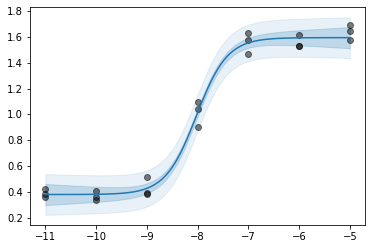

In [36]:
hill_ci, hill_pi = classical_fit_intervals(Hill_eq,p_opt_Hill,lg_c,data,cplot)

plt.plot(lg_c,data,'ko', alpha = 0.5)
plt.fill_between(cplot, hill_y + hill_pi, hill_y - hill_pi, color = 'C0', alpha = 0.1)
plt.fill_between(cplot, hill_y + hill_ci, hill_y - hill_ci, color = 'C0', alpha = 0.2)
plt.plot(cplot,hill_y,'C0');

That's a good visual representation of the uncertainty in the fit, but what about specific fit parameters, such as K<sub>D</sub>? We get the standard errors from the *covariance matrix* of the parameters, then use that to calculate the confidence interval. Whereas above we used a Student's t distribution, here we'll use a normal distribution. Note, __*this assumes your parameters are normally distributed*__. There are many cases where this might not be the cass (particularly if your parameter is near zero and cannot be negative or positive), so interpret with caution.

In [41]:
def classical_fit_param_summary(p_opt,p_cov, names = None):
    nstd = stats.norm.ppf((1. - 0.95)/2.)
    p_std = np.sqrt(np.diag(p_cov))
    p_ci_lower = p_opt - nstd * p_std
    p_ci_upper = p_opt + nstd * p_std
    summary = pd.DataFrame(data = [p_ci_lower,p_opt,p_ci_upper,p_std],
                           index = ('95% CI Lower Limit','Optimal Value','95% CI Upper Limit','Standard Error'),
                           columns = names)
    return summary  

In [42]:
classical_fit_param_summary(p_opt_Hill,p_cov_Hill, names = ('S0','Smax','x_crit','Hill Coefficient'))

,S0,Smax,x_crit,Hill Coefficient
95% CI Lower Limit,0.417630,1.654320,-7.865815,2.399060
Optimal Value,0.379165,1.594292,-8.026005,1.425394
95% CI Upper Limit,0.340699,1.534263,-8.186196,0.451728
Standard Error,0.019626,0.030628,0.081731,0.496778


As __[GraphPad points out](https://www.graphpad.com/guides/prism/7/curve-fitting/index.htm?reg_hill_slope.htm)__,  use caution when interpretting the CI on log-transformed parameters. Because we're in log-space, additive error becomes *multiplicative* error when we transform back into ordinary linear-space. Thus if we have an `x_crit` of -8 and a 95% CI on [-7.5, -8.5] (i.e, [-8-0.5,-8+0.5], the correct way to report this in linear space is 1e-8 with a 95% CI of [0.32e-8,3.2e-8] (i.e., [10<sup>-8</sup>/10<sup>0.5</sup>, 10<sup>-8</sup>*10<sup>0.5</sup>]).

Note that in many cases, particularly for the Hill Coefficient here, the assumption of a symmetric distribution of fit parameters is probably untrue, not to mention the assumption that they specifically result from a normal distribution. Allowing for asymmetric parameters is preferred, and __[newer versions of Prism do that](https://www.graphpad.com/guides/prism/7/user-guide/index.htm?confidence_intervals_and_error.htm)__. There are alternative ways of estimating this confidence interval that allow for asymmetric distributions (namely *bootstrapping* and *Bayesian estimation*), but those are complex and we'll get to them later.

***
## Use extreme caution when applying classical confidence intervals to nonlinear fits
Let's ignore the fits themselves for a second and just look at the confidence intervals we got for our linear and our Hill equations.

Text(0.5, 1.0, 'Hill Fit 95% CI and PI')

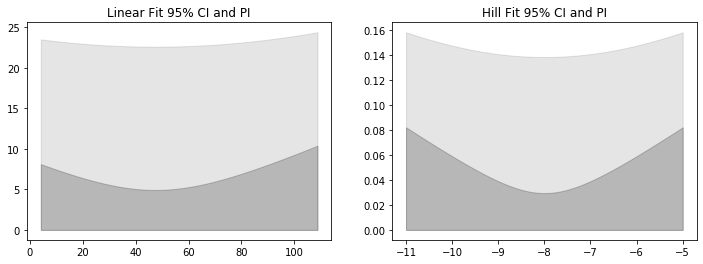

In [45]:
_,axs = plt.subplots(1,2, figsize = (12,4))

axs[0].fill_between(xplot,ci_lin, color = 'k', alpha = 0.2)
axs[0].fill_between(xplot,pi_lin, color = 'k', alpha = 0.1)
axs[0].set_title('Linear Fit 95% CI and PI')

axs[1].fill_between(cplot,hill_ci, color = 'k', alpha = 0.2)
axs[1].fill_between(cplot,hill_pi, color = 'k', alpha = 0.1)
axs[1].set_title('Hill Fit 95% CI and PI')

Those shapes are remarkably similar, even though the data and model are quite different. How can this be? Let's look at the equation for CI again:

$$ \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-m}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}} $$

where $$ \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}} $$

Note that the only place the *y* data are considered is within the $\hat{\sigma}$ term, which is ultimately just a scaling factor to the CI curve. The CI (and PI) from this approach assumes that the noise in your data is spread evenly accross your *x* values, and the degree of certainty depends only on the *density* of *x* values in a given region. If either of these are not true (or, as mentioned above, you have reason to suspect asymmetry in your parameters) you need to use a different approach to generating the CI, as we'll explore later.